# Introduction And Problem Statement

In [213]:
%config IPCompleter.greedy=True
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


Author: Alexandre Menai (amenai@amenai.net)

The purpose of this notebook is to serve as a python machine learning guide for me 
or others wishing to have some fun (most important) and understand the limitations
and Quirks of different AI algorithms.
I am writing this as I am reading the excellent book by Raschka, Sebastian and Vahid Mirjalili:
Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow, 2nd Edition.

I will be using a slightly different set of examples taken from the aviation world
based on multiple factors experienced pilots and regulation impose certain conditions of flights. This lab is an attempt to make decisions based on several physical parameters to fly 
under instrument conditions (IFR) or visual conditions (VFR)
for the sake of discussion we are considering the following parameters: ceiling (cloud altitudes) and visibility
we will assume that the binary decision is possible through those parameters that mimic pilot appreciation. 
<B>CAUTION: PLEASE DO NOT USE THIS FOR FLIGHT DECISION MAKING AND REFER TO YOUR REGULARATORY TEXTS THIS IS JUST AN ILLUSTRATIVE EXAMPLE TO MAKE THE LEARNING PROCESS EASIER!!!</B>



In [214]:
#generate random training data for convenience and save to csv
#initiate a random state for reproductibility of results
rgen=np.random.RandomState(0)
#generate non linearly separable sets
altitudes1 = np.array(rgen.uniform(1800, 2000, 500))
visibilities1 = np.array(rgen.uniform(1,2.95, 500))
altitudes2=np.array(rgen.uniform(2000,2200,500))
visibilities2 = np.array(rgen.uniform(3.05,6,500))
#concatenate into the same set
altitudes=np.concatenate((altitudes1,altitudes2))
visibilities = np.concatenate((visibilities1, visibilities2))
#randomize the sets further
np.random.shuffle(altitudes)
np.random.shuffle(visibilities)
##########################################
#to proceed with a non linearly separable set
#if alt is less than 2000 feet and visi < 3 then IFR otherwise vfr
flightrules = np.array(np.where((altitudes < 2000) & (visibilities < 3), 'ifr', 'vfr'))
pd.DataFrame({'alt': altitudes, 'visi':visibilities,'cond': flightrules}).to_csv('training_set_nonseperable.csv',index=False)
##########################################

##########################################
#to proceed with a linearly separable set
#only consider visibility as the determining factor
flightrules = np.array(np.where((visibilities < 3), 'ifr', 'vfr'))
pd.DataFrame({'alt': altitudes, 'visi':visibilities,'cond': flightrules}).to_csv('training_set.csv',index=False)

Now that we generated the training sets let's take a look at the linrarly sepaparable one more closely

In [215]:

df.tail(10)

,alt,visi,cond
990,2122.953977,5.404333,vfr
991,2188.436944,1.345161,vfr
992,2117.221588,1.001065,vfr
993,1807.072487,2.317594,ifr
994,2193.018995,3.493532,vfr
995,1847.561449,1.195027,ifr
996,1837.046465,1.166356,ifr
997,1924.295680,4.413188,vfr
998,2156.679329,3.752019,vfr
999,1902.003370,4.264298,vfr


If we were to consider that IFR conditions need to meet both visibility and ceiling criteria
then our problem of classification our phenomenon is NOT linearly separable:

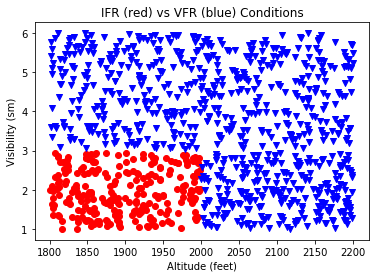

In [216]:
#Load it as a numpy array
trainingset=np.array(df)
#np.random.shuffle(trainingset)
# input
conditions = np.array(df)[:,[0,1]]
# output
decision = np.array(df)[:,2]

IFR=conditions[(conditions[:,0]<2000) & (conditions[:,1]<3)]
VFR=conditions[(conditions[:,0]>2000) | (conditions[:,1]>3)]
plt.scatter(IFR[:,0],IFR[:,1],color='red',marker='o')
plt.scatter(VFR[:, 0], VFR[:, 1], color='blue',marker='v')
plt.xlabel('Altitude (feet)')
plt.ylabel('Visibility (sm)')
plt.title('IFR (red) vs VFR (blue) Conditions')

If we were to consider that IFR conditions need to meet ONLY the visibility criteria
then our problem of classification our phenomenon IS linearly separable:

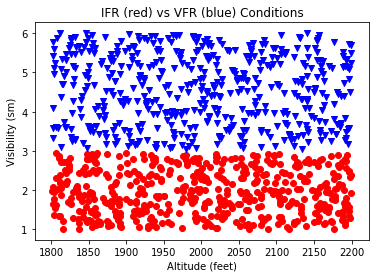

In [217]:

IFR = conditions[(conditions[:, 1] < 3)]
VFR=conditions[(conditions[:,1]>3)]
plt.scatter(IFR[:,0],IFR[:,1],color='red',marker='o')
plt.scatter(VFR[:, 0], VFR[:, 1], color='blue',marker='v')
plt.xlabel('Altitude (feet)')
plt.ylabel('Visibility (sm)')
plt.title('IFR (red) vs VFR (blue) Conditions')

# Teaching The Computer How to Make Decisions

For the rest of this Kab we will be playing with diferent algorithms to solve our decision making problem of IFR vs VFR. We have on purpose made the problem linearly separable to apply the most simplistic algorithms first.

## Splitting our data sample in to a Training Set and a Testing Set

For computing convenience let's first change the decision array from 'vfr','ifr' to +1,-1 respectively.

In [218]:
binary_decision = np.where(decision == 'vfr', 1, -1)

In [219]:
from sklearn.model_selection import train_test_split
conditions_train, conditions_test, binary_decision_train, binary_decision_test = train_test_split(
    conditions, binary_decision, test_size=0.3, random_state=1, stratify=binary_decision)

Verify that the training set and the test set have the same distribution

In [220]:
#np.bincount does not qccpt negative ints so we replaced -1 by 0
print('Labels counts in binary_decision:', np.bincount(np.where(binary_decision==-1,0,1)))
print('Labels counts in binary_decision_train:', np.bincount(np.where(binary_decision_train==-1,0,1)))
print('Labels counts in binary_decision_test:', np.bincount(np.where(binary_decision_test==-1,0,1)))

Labels counts in binary_decision: [248 752]
Labels counts in binary_decision_train: [174 526]
Labels counts in binary_decision_test: [ 74 226]


Standardizing the features to numbers between 0 and 1 seems to be more convenient and helps most algorithms deal with smaller numbers so the execute and converge faster.

In [221]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(conditions_train)
#what this does is normalize every feature value to its mean and standard deviation 
#this is equivalent to the the following operations:
#conditions_std=np.copy(conditions)
#conditions_std[:,0]=(conditions[:,0]-conditions[:,0].mean())/conditions[:,0].std()
#conditions_std[:,1] = (conditions[:, 1] - conditions[:, 1].mean()) / conditions[:, 1].std()
conditions_train_std = sc.transform(conditions_train)
conditions_test_std = sc.transform(conditions_test)
#verify before / after
print(conditions_test[0][0])
print(conditions_test_std[0][0])

2061.0093396725724
0.558810170773


/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Teaching a Perceptron

for a <a href="https://en.wikipedia.org/wiki/Perceptron">refresher on perceptrons</a>
<img src="https://rasbt.github.io/mlxtend/user_guide/classifier/Perceptron_files/perceptron_schematic.png" width ="300" />

### Linearily Seprable Case

In [222]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
#initialize a perceptron
ppn = Perceptron(max_iter=1000, eta0=0.01, random_state=100,fit_intercept=True)
#train it
ppn.fit(conditions_train_std, binary_decision_train)
#test it
binary_decision_pred = ppn.predict(conditions_test_std)
print('Misclassified samples: %d' % (binary_decision_test != binary_decision_pred).sum())
print('Accuracy: %.2f' % accuracy_score(binary_decision_test, binary_decision_pred))
print('Accuracy: %.2f' % ppn.score(conditions_test_std, binary_decision_test))
print(ppn.coef_)

Misclassified samples: 23
Accuracy: 0.92
Accuracy: 0.92
[[ 0.02915366  0.0289705 ]]


Hmmm, looks pretty accurate Let's look at how the learning went progressively and set fit_intercept=False in order not to make it easy on the perceptron (be patient)

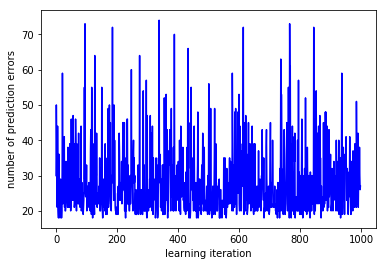

[[ 0.02952413  0.02191557]]


In [223]:
errors=[]
for _ in range(1,1000):
    ppn = Perceptron(max_iter=_, eta0=0.01, random_state=100,fit_intercept=True,shuffle=True)
    #train it
    ppn.fit(conditions_train_std, binary_decision_train)
    #test it
    binary_decision_pred = ppn.predict(conditions_test_std)
    errors.append((binary_decision_test != binary_decision_pred).sum())

plt.plot(range(len(errors)),errors,color='blue',marker='')
plt.xlabel('learning iteration')
plt.ylabel('number of prediction errors')
plt.show()
print(ppn.coef_)

### Non Linearily Separable

In [224]:
df = pd.read_csv('training_set_nonseperable.csv')
df.tail()

,alt,visi,cond
995,1859.228040,3.393567,vfr
996,2016.758271,1.273749,vfr
997,2183.283802,1.679528,vfr
998,1884.937094,2.418717,ifr
999,1994.851243,1.617176,ifr


In [225]:
#Load it as a numpy array
trainingset=np.array(df)
#np.random.shuffle(trainingset)
# input
conditions = np.array(df)[:,[0,1]]
# output
decision = np.array(df)[:,2]

#preprocessing

binary_decision = np.where(decision == 'vfr', 1, -1)
from sklearn.model_selection import train_test_split
conditions_train, conditions_test, binary_decision_train, binary_decision_test = train_test_split(
    conditions, binary_decision, test_size=0.3, random_state=1, stratify=binary_decision)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(conditions_train)
#what this does is normalize every feature value to its mean and standard deviation 
#this is equivalent to the the following operations:
#conditions_std=np.copy(conditions)
#conditions_std[:,0]=(conditions[:,0]-conditions[:,0].mean())/conditions[:,0].std()
#conditions_std[:,1] = (conditions[:, 1] - conditions[:, 1].mean()) / conditions[:, 1].std()
conditions_train_std = sc.transform(conditions_train)
conditions_test_std = sc.transform(conditions_test)
#verify before / after
print(conditions_test[0][0])
print(conditions_test_std[0][0])

#Learning
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
#initialize a perceptron
ppn = Perceptron(max_iter=1000, eta0=0.01, random_state=100,fit_intercept=True)
#train it
ppn.fit(conditions_train_std, binary_decision_train)
#test it
binary_decision_pred = ppn.predict(conditions_test_std)
print('Misclassified samples: %d' % (binary_decision_test != binary_decision_pred).sum())
print('Accuracy: %.2f' % accuracy_score(binary_decision_test, binary_decision_pred))
print('Accuracy: %.2f' % ppn.score(conditions_test_std, binary_decision_test))
print(ppn.coef_)

2158.2454862038226
1.31500475825
Misclassified samples: 27
Accuracy: 0.91
Accuracy: 0.91
[[ 0.02357042  0.04307217]]


/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


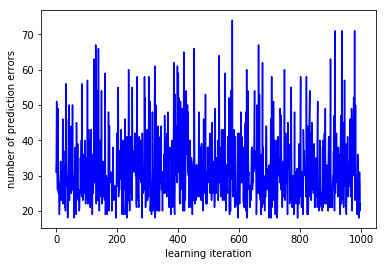

[[ 0.02942106  0.0304286 ]]


In [226]:
errors=[]
for _ in range(1,1000):
    ppn = Perceptron(max_iter=_, eta0=0.01, random_state=100,fit_intercept=True,shuffle=True)
    #train it
    ppn.fit(conditions_train_std, binary_decision_train)
    #test it
    binary_decision_pred = ppn.predict(conditions_test_std)
    errors.append((binary_decision_test != binary_decision_pred).sum())

plt.plot(range(len(errors)),errors,color='blue',marker='')
plt.xlabel('learning iteration')
plt.ylabel('number of prediction errors')
plt.show()
print(ppn.coef_)

Not as easy :)